In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr
import torch
import nibabel as nib

sys.path.append('..')
import project

torch.cuda.is_available()

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv001
--------------------------------------------------------------------------


True

In [3]:
emory4dct = project.imaging.Emory4DCT('../data/Emory-4DCT')
emory4dct.load_niftis()
emory4dct.load_masks(roi='lung_combined_mask')

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T00.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T10.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T20.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T30.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T40.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T50.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIF

Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T60/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T70/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T80/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T90/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/TotalSegment/case4_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/TotalSegment/case4_T10/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/TotalSegment/case4_T20/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/TotalSegment/case4_T30/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/TotalSegment/case4_T40/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/TotalSegment/case4_T50/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/TotalSegment/case4_T60/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/TotalSegment/case

<IPython.core.display.Javascript object>


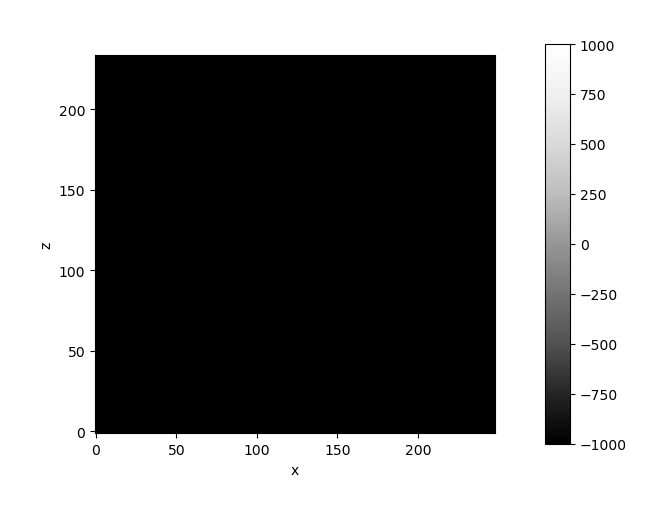

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

In [4]:
case = emory4dct[0]
project.visual.view(case.anat + case.mask * 1000, y='z', cmap='Greys_r', vmin=-1000, vmax=1000)

In [5]:
%%time
sys.path.append('../../Lung250M-4B')
from corrfield.corrfield import corrfield

for case in emory4dct.cases:
    for phase_fix in emory4dct.phases:
        for phase_mov in emory4dct.phases:
            print(f'Registering {case.case_name} phase {phase_mov} to phase {phase_fix}')

            anat_mov = case.anat.sel(phase=phase_mov).values
            anat_fix = case.anat.sel(phase=phase_fix).values
            mask_fix = case.mask.sel(phase=phase_fix, roi='lung_combined_mask').values

            try:
                disp, _, _ = corrfield(
                    img_mov=torch.as_tensor(anat_mov, dtype=torch.float).unsqueeze(0).unsqueeze(0).cuda(),
                    img_fix=torch.as_tensor(anat_fix, dtype=torch.float).unsqueeze(0).unsqueeze(0).cuda(),
                    mask_fix=torch.as_tensor(mask_fix, dtype=torch.float).unsqueeze(0).unsqueeze(0).cuda(),
                )
            except RuntimeError as e:
                print(case, phase_fix, phase_mov)
                raise

            disp = disp[0].detach().cpu().numpy()
            print(disp.shape)

            affine = np.diag(list(case.resolution) + [1])
            disp_file = case.disp_file(phase_mov, phase_fix)

            print(f'Saving {disp_file}')
            nib.save(nib.nifti1.Nifti1Image(disp, affine), disp_file)


Registering Case1Pack phase 0 to phase 0
Compute fixed MIND features ... 

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../Lung250M-4B/corrfield/mindssc.py:52: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  F.conv3d(rpad(img), mshift1, dilation=delta) -


finished (0.39 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    722 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... 

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../Lung250M-4B/corrfield/graphs.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/torch/csrc/utils/tensor_new.cpp:274.)
  edges = torch.tensor(


finished (0.58 s).
    Compute symmetric backward marginals ... finished (0.53 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1477 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.40 s).
    Compute symmetric backward marginals ... finished (0.42 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case1Pack/CorrField/case1_T00_T00.nii.gz
Registering Case1Pack phase 10 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    722 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.54 s).
    C

    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.50 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1450 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.40 s).
    Compute symmetric backward marginals ... finished (0.38 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case1Pack/CorrField/case1_T70_T10.nii.gz
Registering Case1Pack phase 80 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    714 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.37 s).
    Compute symmetric backward marginals ... finished (0.38 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case1Pack/CorrField/case1_T50_T20.nii.gz
Registering Case1Pack phase 60 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    674 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.51 s).
    Compute symmetric backward marginals ... finished (0.47 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1343 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.51 s).
    Compute symmetric backward marginals ... finished (0.51 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1334 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.36 s).
    Compute symmetric backward marginals ... finished (0.35 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case1Pack/CorrField/case1_T40_T30.nii.gz
Registering Case1Pack phase 50 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    681 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.39 s).
    Compute symmetric backward marginals ... finished (0.39 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case1Pack/CorrField/case1_T20_T40.nii.gz
Registering Case1Pack phase 30 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    669 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.46 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1339 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.52 s).
    Compute symmetric backward marginals ... finished (0.49 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1316 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.33 s).
    Compute symmetric backward marginals ... finished (0.35 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case1Pack/CorrField/case1_T10_T50.nii.gz
Registering Case1Pack phase 20 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    672 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.33 s).
    Compute symmetric backward marginals ... finished (0.36 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case1Pack/CorrField/case1_T90_T50.nii.gz
Registering Case1Pack phase 0 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    662 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.48 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1317 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1317 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.34 s).
    Compute symmetric backward marginals ... finished (0.35 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case1Pack/CorrField/case1_T80_T60.nii.gz
Registering Case1Pack phase 90 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    662 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.33 s).
    Compute symmetric backward marginals ... finished (0.35 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case1Pack/CorrField/case1_T60_T70.nii.gz
Registering Case1Pack phase 70 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    682 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.46 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1345 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.49 s).
    Compute symmetric backward marginals ... finished (0.47 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1389 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.40 s).
    Compute symmetric backward marginals ... finished (0.37 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case1Pack/CorrField/case1_T50_T80.nii.gz
Registering Case1Pack phase 60 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    689 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.37 s).
    Compute symmetric backward marginals ... finished (0.36 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case1Pack/CorrField/case1_T30_T90.nii.gz
Registering Case1Pack phase 40 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    724 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.54 s).
    Compute symmetric backward marginals ... finished (0.50 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1433 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.68 s).
    Compute symmetric backward marginals ... finished (0.64 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1807 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.50 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T20_T00.nii.gz
Registering Case2Pack phase 30 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    917 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.43 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T00_T10.nii.gz
Registering Case2Pack phase 10 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    877 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.65 s).
    Compute symmetric backward marginals ... finished (0.65 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1687 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.66 s).
    Compute symmetric backward marginals ... finished (0.60 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1687 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.43 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T90_T10.nii.gz
Registering Case2Pack phase 0 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    893 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.47 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T70_T20.nii.gz
Registering Case2Pack phase 80 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    893 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.65 s).
    Compute symmetric backward marginals ... finished (0.65 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1702 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.66 s).
    Compute symmetric backward marginals ... finished (0.66 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1701 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.42 s).
    Compute symmetric backward marginals ... finished (0.41 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T60_T30.nii.gz
Registering Case2Pack phase 70 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    911 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.41 s).
    Compute symmetric backward marginals ... finished (0.43 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T40_T40.nii.gz
Registering Case2Pack phase 50 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    891 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.62 s).
    Compute symmetric backward marginals ... finished (0.62 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1689 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.63 s).
    Compute symmetric backward marginals ... finished (0.61 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1693 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.42 s).
    Compute symmetric backward marginals ... finished (0.43 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T30_T50.nii.gz
Registering Case2Pack phase 40 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    897 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.46 s).
    Compute symmetric backward marginals ... finished (0.43 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T10_T60.nii.gz
Registering Case2Pack phase 20 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    874 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.61 s).
    Compute symmetric backward marginals ... finished (0.66 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1656 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.59 s).
    Compute symmetric backward marginals ... finished (0.60 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1652 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T00_T70.nii.gz
Registering Case2Pack phase 10 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    860 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.48 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T80_T70.nii.gz
Registering Case2Pack phase 90 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    860 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.60 s).
    Compute symmetric backward marginals ... finished (0.62 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1652 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.67 s).
    Compute symmetric backward marginals ... finished (0.62 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1687 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T70_T80.nii.gz
Registering Case2Pack phase 80 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    890 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T50_T90.nii.gz
Registering Case2Pack phase 60 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    943 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.70 s).
    Compute symmetric backward marginals ... finished (0.71 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1790 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.65 s).
    Compute symmetric backward marginals ... finished (0.66 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1743 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.50 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T40_T00.nii.gz
Registering Case3Pack phase 50 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    903 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.42 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T20_T10.nii.gz
Registering Case3Pack phase 30 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    824 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.58 s).
    Compute symmetric backward marginals ... finished (0.58 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1635 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.63 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1649 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.47 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T10_T20.nii.gz
Registering Case3Pack phase 20 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    868 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T90_T20.nii.gz
Registering Case3Pack phase 0 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    851 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.66 s).
    Compute symmetric backward marginals ... finished (0.59 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1611 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.66 s).
    Compute symmetric backward marginals ... finished (0.62 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1611 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.40 s).
    Compute symmetric backward marginals ... finished (0.41 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T80_T30.nii.gz
Registering Case3Pack phase 90 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    851 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.50 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T60_T40.nii.gz
Registering Case3Pack phase 70 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    824 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.65 s).
    Compute symmetric backward marginals ... finished (0.61 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1613 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.64 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1587 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.40 s).
    Compute symmetric backward marginals ... finished (0.39 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T50_T50.nii.gz
Registering Case3Pack phase 60 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    839 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.38 s).
    Compute symmetric backward marginals ... finished (0.39 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T30_T60.nii.gz
Registering Case3Pack phase 40 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    826 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.58 s).
    Compute symmetric backward marginals ... finished (0.58 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1609 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.63 s).
    Compute symmetric backward marginals ... finished (0.61 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1628 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T20_T70.nii.gz
Registering Case3Pack phase 30 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    826 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.43 s).
    Compute symmetric backward marginals ... finished (0.43 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T00_T80.nii.gz
Registering Case3Pack phase 10 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    870 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.66 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1666 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.65 s).
    Compute symmetric backward marginals ... finished (0.65 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1666 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.43 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T90_T80.nii.gz
Registering Case3Pack phase 0 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    861 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.46 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T70_T90.nii.gz
Registering Case3Pack phase 80 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    861 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.62 s).
    Compute symmetric backward marginals ... finished (0.65 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1728 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.66 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1654 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.59 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T60_T00.nii.gz
Registering Case4Pack phase 70 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    857 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.54 s).
    Compute symmetric backward marginals ... finished (0.56 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T40_T10.nii.gz
Registering Case4Pack phase 50 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    818 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.60 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1614 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.62 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1593 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.53 s).
    Compute symmetric backward marginals ... finished (0.73 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T30_T20.nii.gz
Registering Case4Pack phase 40 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    820 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.52 s).
    Compute symmetric backward marginals ... finished (0.51 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T10_T30.nii.gz
Registering Case4Pack phase 20 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    776 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.61 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1556 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.67 s).
    Compute symmetric backward marginals ... finished (0.62 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1523 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.67 s).
    Compute symmetric backward marginals ... finished (0.67 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T00_T40.nii.gz
Registering Case4Pack phase 10 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    776 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.67 s).
    Compute symmetric backward marginals ... finished (0.66 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T80_T40.nii.gz
Registering Case4Pack phase 90 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    776 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.68 s).
    Compute symmetric backward marginals ... finished (0.65 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1523 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.64 s).
    Compute symmetric backward marginals ... finished (0.61 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1519 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.64 s).
    Compute symmetric backward marginals ... finished (0.66 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T70_T50.nii.gz
Registering Case4Pack phase 80 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    768 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.52 s).
    Compute symmetric backward marginals ... finished (0.53 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T50_T60.nii.gz
Registering Case4Pack phase 60 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    745 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.61 s).
    Compute symmetric backward marginals ... finished (0.60 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1480 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.58 s).
    Compute symmetric backward marginals ... finished (0.58 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1443 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T40_T70.nii.gz
Registering Case4Pack phase 50 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    727 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.47 s).
    Compute symmetric backward marginals ... finished (0.47 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T20_T80.nii.gz
Registering Case4Pack phase 30 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    752 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.62 s).
    Compute symmetric backward marginals ... finished (0.59 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1471 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.62 s).
    Compute symmetric backward marginals ... finished (0.61 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1600 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.53 s).
    Compute symmetric backward marginals ... finished (0.58 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T10_T90.nii.gz
Registering Case4Pack phase 20 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    791 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.53 s).
    Compute symmetric backward marginals ... finished (0.53 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T90_T90.nii.gz
Registering Case5Pack phase 0 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    709 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.51 s).
    Compute symmetric backward marginals ... finished (0.51 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1328 fixed keypoints extracted (0.03 s).
    Compute forward margi

    Compute forward marginals ... finished (0.51 s).
    Compute symmetric backward marginals ... finished (0.50 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1328 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.36 s).
    Compute symmetric backward marginals ... finished (0.36 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T80_T00.nii.gz
Registering Case5Pack phase 90 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    709 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.35 s).
    Compute symmetric backward marginals ... finished (0.35 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T60_T10.nii.gz
Registering Case5Pack phase 70 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    638 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.46 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1265 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.46 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1247 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.32 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T50_T20.nii.gz
Registering Case5Pack phase 60 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    633 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.32 s).
    Compute symmetric backward marginals ... finished (0.31 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T30_T30.nii.gz
Registering Case5Pack phase 40 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    639 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1221 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.48 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1256 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.33 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T20_T40.nii.gz
Registering Case5Pack phase 30 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    677 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (4.16 s).
    Compute symmetric backward marginals ... finished (0.42 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T00_T50.nii.gz
Registering Case5Pack phase 10 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    635 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1226 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.43 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1226 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T90_T50.nii.gz
Registering Case5Pack phase 0 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    629 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T70_T60.nii.gz
Registering Case5Pack phase 80 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    629 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.51 s).
    Compute symmetric backward marginals ... finished (0.43 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1230 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1228 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.33 s).
    Compute symmetric backward marginals ... finished (0.32 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T60_T70.nii.gz
Registering Case5Pack phase 70 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    628 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.34 s).
    Compute symmetric backward marginals ... finished (0.34 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T40_T80.nii.gz
Registering Case5Pack phase 50 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    662 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.52 s).
    Compute symmetric backward marginals ... finished (0.51 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1273 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.53 s).
    Compute symmetric backward marginals ... finished (0.54 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1326 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.46 s).
    Compute symmetric backward marginals ... finished (0.50 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T30_T90.nii.gz
Registering Case5Pack phase 40 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    700 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.24 s).
    Compute symmetric backward marginals ... finished (0.29 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T10_T00.nii.gz
Registering Case6Pack phase 20 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    469 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.33 s).
    Compute symmetric backward marginals ... finished (0.32 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    875 fixed keypoints extracted (0.03 s).
    Compute forward margi

    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    858 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T00_T10.nii.gz
Registering Case6Pack phase 10 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    434 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.29 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T80_T10.nii.gz
Registering Case6Pack phase 90 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    434 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.32 s).
    Compute symmetric backward marginals ... finished (0.31 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    858 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    795 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T70_T20.nii.gz
Registering Case6Pack phase 80 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    400 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.29 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T50_T30.nii.gz
Registering Case6Pack phase 60 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    390 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    779 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    742 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T40_T40.nii.gz
Registering Case6Pack phase 50 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    380 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.26 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T20_T50.nii.gz
Registering Case6Pack phase 30 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    384 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    734 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.29 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    711 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.20 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T10_T60.nii.gz
Registering Case6Pack phase 20 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    351 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.20 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T90_T60.nii.gz
Registering Case6Pack phase 0 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    355 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.25 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    717 fixed keypoints extracted (0.03 s).
    Compute forward margi

    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.24 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    717 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.25 s).
    Compute symmetric backward marginals ... finished (0.24 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T80_T70.nii.gz
Registering Case6Pack phase 90 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    355 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T60_T80.nii.gz
Registering Case6Pack phase 70 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    416 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.33 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    779 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    819 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.21 s).
    Compute symmetric backward marginals ... finished (0.25 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T50_T90.nii.gz
Registering Case6Pack phase 60 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    425 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T30_T00.nii.gz
Registering Case7Pack phase 40 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    436 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    841 fixed keypoints extracted (0.03 s).
    Compute forward margi

    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    790 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.23 s).
    Compute symmetric backward marginals ... finished (0.23 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T20_T10.nii.gz
Registering Case7Pack phase 30 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    402 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.20 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T00_T20.nii.gz
Registering Case7Pack phase 10 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    383 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    728 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    728 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.20 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T90_T20.nii.gz
Registering Case7Pack phase 0 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    360 fixed keypoints extracted (0.04 s).
    Compute forward margi

    Compute forward marginals ... finished (0.20 s).
    Compute symmetric backward marginals ... finished (0.19 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T70_T30.nii.gz
Registering Case7Pack phase 80 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    360 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    710 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.25 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    705 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.19 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T60_T40.nii.gz
Registering Case7Pack phase 70 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    370 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.23 s).
    Compute symmetric backward marginals ... finished (0.21 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T40_T50.nii.gz
Registering Case7Pack phase 50 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    355 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.25 s).
    Compute symmetric backward marginals ... finished (0.24 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    730 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.24 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    717 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.23 s).
    Compute symmetric backward marginals ... finished (0.23 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T30_T60.nii.gz
Registering Case7Pack phase 40 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    364 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.20 s).
    Compute symmetric backward marginals ... finished (0.21 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T10_T70.nii.gz
Registering Case7Pack phase 20 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    342 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.25 s).
    Compute symmetric backward marginals ... finished (0.23 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    676 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.29 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    748 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.21 s).
    Compute symmetric backward marginals ... finished (0.22 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T00_T80.nii.gz
Registering Case7Pack phase 10 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    400 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.21 s).
    Compute symmetric backward marginals ... finished (0.21 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T80_T80.nii.gz
Registering Case7Pack phase 90 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    400 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.35 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    748 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    764 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.21 s).
    Compute symmetric backward marginals ... finished (0.22 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T70_T90.nii.gz
Registering Case7Pack phase 80 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    405 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.38 s).
    Compute symmetric backward marginals ... finished (0.37 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T50_T00.nii.gz
Registering Case8Deploy phase 60 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    685 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.48 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1280 fixed keypoints extracted (0.03 s).
    Compute forward 

    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1210 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.32 s).
    Compute symmetric backward marginals ... finished (0.33 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T40_T10.nii.gz
Registering Case8Deploy phase 50 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    646 fixed keypoints extracted (0.04 s).
    Compute forward

    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T20_T20.nii.gz
Registering Case8Deploy phase 30 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    597 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.47 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1121 fixed keypoints extracted (0.03 s).
    Compute forward

    Compute forward marginals ... finished (0.47 s).
    Compute symmetric backward marginals ... finished (0.47 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1062 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.29 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T10_T30.nii.gz
Registering Case8Deploy phase 20 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    591 fixed keypoints extracted (0.04 s).
    Compute forward

    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T90_T30.nii.gz
Registering Case8Deploy phase 0 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    590 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1111 fixed keypoints extracted (0.03 s).
    Compute forward 

    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1111 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.29 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T80_T40.nii.gz
Registering Case8Deploy phase 90 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    590 fixed keypoints extracted (0.04 s).
    Compute forward

    Compute forward marginals ... finished (0.33 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T60_T50.nii.gz
Registering Case8Deploy phase 70 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    619 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1110 fixed keypoints extracted (0.03 s).
    Compute forward

    Compute forward marginals ... finished (0.41 s).
    Compute symmetric backward marginals ... finished (0.40 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1060 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T50_T60.nii.gz
Registering Case8Deploy phase 60 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    567 fixed keypoints extracted (0.04 s).
    Compute forward

    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T30_T70.nii.gz
Registering Case8Deploy phase 40 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    554 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.40 s).
    Compute symmetric backward marginals ... finished (0.38 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1048 fixed keypoints extracted (0.03 s).
    Compute forward

    Compute forward marginals ... finished (0.42 s).
    Compute symmetric backward marginals ... finished (0.42 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1093 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T20_T80.nii.gz
Registering Case8Deploy phase 30 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    605 fixed keypoints extracted (0.04 s).
    Compute forward

    Compute forward marginals ... finished (0.37 s).
    Compute symmetric backward marginals ... finished (0.34 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T00_T90.nii.gz
Registering Case8Deploy phase 10 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    632 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1192 fixed keypoints extracted (0.03 s).
    Compute forward

    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1192 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.37 s).
    Compute symmetric backward marginals ... finished (0.37 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T90_T90.nii.gz
Registering Case9Pack phase 0 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    242 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.16 s).
    Compute symmetric backward marginals ... finished (0.16 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T70_T00.nii.gz
Registering Case9Pack phase 80 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    242 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.18 s).
    Compute symmetric backward marginals ... finished (0.18 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    511 fixed keypoints extracted (0.03 s).
    Compute forward margi

    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.18 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    495 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.15 s).
    Compute symmetric backward marginals ... finished (0.16 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T60_T10.nii.gz
Registering Case9Pack phase 70 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    260 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute symmetric backward marginals ... finished (0.13 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T40_T20.nii.gz
Registering Case9Pack phase 50 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    248 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.18 s).
    Compute symmetric backward marginals ... finished (0.17 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    492 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.14 s).
    Compute symmetric ba

    Compute forward marginals ... finished (0.17 s).
    Compute symmetric backward marginals ... finished (0.17 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    491 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.13 s).
    Compute symmetric backward marginals ... finished (0.13 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T30_T30.nii.gz
Registering Case9Pack phase 40 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    235 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute symmetric backward marginals ... finished (0.12 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T10_T40.nii.gz
Registering Case9Pack phase 20 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    234 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.18 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    475 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.12 s).
    Compute symmetric ba

    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.17 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    502 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.14 s).
    Compute symmetric backward marginals ... finished (0.14 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T00_T50.nii.gz
Registering Case9Pack phase 10 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    254 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.14 s).
    Compute symmetric backward marginals ... finished (0.13 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T80_T50.nii.gz
Registering Case9Pack phase 90 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    254 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.17 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    502 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.18 s).
    Compute symmetric backward marginals ... finished (0.17 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    438 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.11 s).
    Compute symmetric backward marginals ... finished (0.11 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T70_T60.nii.gz
Registering Case9Pack phase 80 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    223 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.14 s).
    Compute symmetric backward marginals ... finished (0.14 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T50_T70.nii.gz
Registering Case9Pack phase 60 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    241 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.18 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    477 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.20 s).
    Compute symmetric backward marginals ... finished (0.19 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    487 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.14 s).
    Compute symmetric backward marginals ... finished (0.15 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T40_T80.nii.gz
Registering Case9Pack phase 50 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    253 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.14 s).
    Compute symmetric backward marginals ... finished (0.14 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T20_T90.nii.gz
Registering Case9Pack phase 30 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    260 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.18 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    522 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.36 s).
    Compute symmetric backward marginals ... finished (0.36 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1020 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T10_T00.nii.gz
Registering Case10Pack phase 20 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    508 fixed keypoints extracted (0.04 s).
    Compute forward m

    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.31 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T90_T00.nii.gz
Registering Case10Pack phase 0 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    487 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.35 s).
    Compute symmetric backward marginals ... finished (0.38 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    961 fixed keypoints extracted (0.03 s).
    Compute forward ma

    Compute forward marginals ... finished (0.36 s).
    Compute symmetric backward marginals ... finished (0.36 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    961 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T80_T10.nii.gz
Registering Case10Pack phase 90 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    487 fixed keypoints extracted (0.04 s).
    Compute forward m

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.26 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T60_T20.nii.gz
Registering Case10Pack phase 70 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    441 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.32 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    882 fixed keypoints extracted (0.03 s).
    Compute forward m

    Compute forward marginals ... finished (0.32 s).
    Compute symmetric backward marginals ... finished (0.31 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    867 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.25 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T50_T30.nii.gz
Registering Case10Pack phase 60 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    454 fixed keypoints extracted (0.04 s).
    Compute forward m

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.24 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T30_T40.nii.gz
Registering Case10Pack phase 40 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    446 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    883 fixed keypoints extracted (0.03 s).
    Compute forward m

    Compute moving MIND features ... finished (0.04 s).
    445 fixed keypoints extracted (0.53 s).
    Compute forward marginals ... finished (1.38 s).
    Compute symmetric backward marginals ... finished (0.32 s).
    Dense thin plate spline interpolation ... finished (2.16 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    882 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.25 s).
    Compute symmetric backward marginals ... finished (0.26 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T20_T50.nii.gz
Registering Case10Pack phase 30 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MI

    Compute moving MIND features ... finished (0.04 s).
    850 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.22 s).
    Compute symmetric backward marginals ... finished (0.23 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T00_T60.nii.gz
Registering Case10Pack phase 10 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    409 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MI

Registering Case10Pack phase 90 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    409 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    850 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.22 s).
    Compute symmetric backward marginals ... finished (0.22 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T90_T60.nii.gz
Registering Case10Pac

    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    876 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.26 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T70_T70.nii.gz
Registering Case10Pack phase 80 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    431 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.29 s).
    Compute symmetric

    Compute forward marginals ... finished (0.32 s).
    Compute symmetric backward marginals ... finished (0.33 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    942 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T40_T90.nii.gz
Registering Case10Pack phase 50 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    466 fixed keypoints extracted (0.04 s).
    Compute forward m

In [6]:
emory4dct.load_displacements(fixed_phase=0, relative=False)

Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T00_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T10_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T20_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T30_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T40_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T50_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T60_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T70_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T80_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T90_T00.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/CorrField/case2_T00_T00.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/CorrField/case2_T10_T00.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/CorrField/case2_T20_T00.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/CorrField/case2_T30_T00.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/CorrField/c

<IPython.core.display.Javascript object>


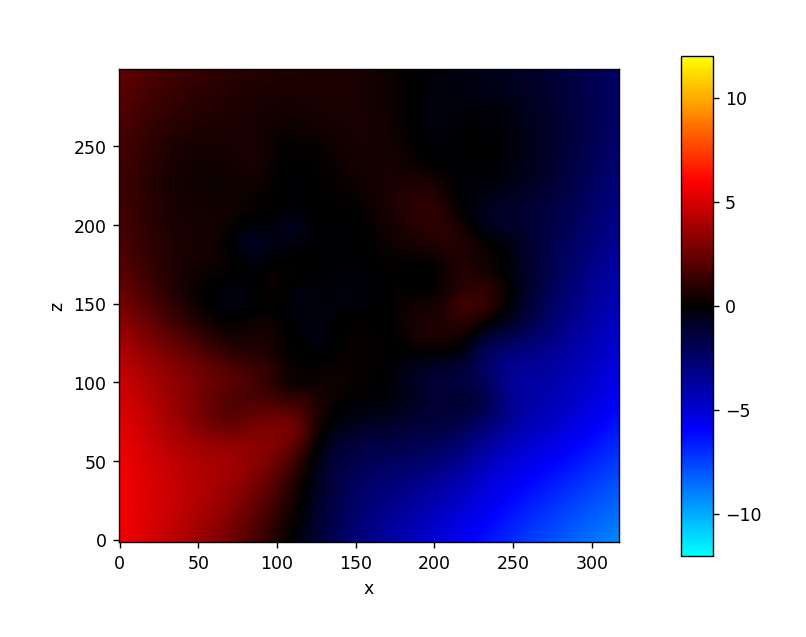

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

In [12]:
project.visual.view(emory4dct[9].disp, y='z')